In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
import tensorflow.keras as keras

/home/assiene/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU

In [4]:
from DataPreprocessing import DataPreprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [5]:
class RNNModel:
    
    def __init__(self, sequence_length, num_features):
        self.num_features = num_features
        self.sequence_length = sequence_length
        print("")
        
    #parameters set using grid search should have a default value specified in the "__call__" method
    def __call__(self, neurons=128, rnn_type="LSTM"):
        
        if rnn_type == "LSTM":
            rnn = LSTM(neurons, input_shape=(self.sequence_length, self.num_features))
        elif rnn_type == "GRU":
            rnn = GRU(neurons, input_shape=(self.sequence_length, self.num_features))
        elif rnn_type == "Vanilla":
            rnn = SimpleRNN(neurons, input_shape=(self.sequence_length, self.num_features))
        
        lstm_model = Sequential()
        lstm_model.add(rnn)
        lstm_model.add(Dense(units=1))
        lstm_model.add(Activation('relu'))
        
        lstm_model.compile(loss='mse',
              optimizer="adam")
        
        return lstm_model

In [6]:
def grid_search(model_informations, df):
    model = KerasRegressor(build_fn=model_informations["model"])
    DP = DataPreprocessing()

    epochs = [20]
    batches = [128]
    neurons = [8, 16] #You can add more values but it will be much more expensive
    rnn_type = ["GRU"] #You can try "LSTM" and "Vanilla" for example but it will be much more expensive
    
    param_grid = dict(epochs=epochs, batch_size=batches, rnn_type=rnn_type, neurons=neurons)
    grid = GridSearchCV(estimator=model, param_grid=param_grid)
    X, y = DP.create_dataset_in_time_series_form(entire_dataframe=df, time_series_column="Rainfall", time_horizon=40, output_form="keras")
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    grid_result = grid.fit(X_train, y_train)
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
    	print("%f (%f) with: %r" % (mean, stdev, param))
        
    return means, stds, params


In [13]:
def plot_grid_search_results(models_results, station_name):
    import matplotlib.pyplot as plt

    xvalues = [8,16]
    folds = np.array(xvalues)
    fig = plt.figure(figsize=(11,8))
    ax1 = fig.add_subplot(111)
    
    for current_model in models_results:
        ax1.plot(folds, current_model["values"], label=current_model["name"], color=current_model["color"], marker = "o")
        
    plt.xticks(folds)
    plt.xlabel("Neurons")
    handles, labels = ax1.get_legend_handles_labels()
    lgd = ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
    ax1.grid('on')
    
    plt.legend(loc='best')
    plt.savefig(station_name + ".png")
    
    plt.show()

In [8]:
df = pd.read_csv("../WorkstationsData/1.csv", header=None, names=["StationIndex", "StationName", "Year", "Month", "Day", "Rainfall"])

In [9]:
models = []
models_results = []

models.append({"name": "RNN", "model": RNNModel(sequence_length=40, num_features=1), "datasets_form": "RNN", "color": "c"})

In [10]:
for model in models:
    means, stds, params = grid_search(model, df[["Rainfall"]])
    models_results.append({"name": model["name"], "values": means, "color": model["color"]})

Epoch 1/20
8536/8536 [==============================] - 1s 152us/step - loss: 283.4914
Epoch 2/20
8536/8536 [==============================] - 1s 108us/step - loss: 273.2986
Epoch 3/20
8536/8536 [==============================] - 1s 107us/step - loss: 264.7059
Epoch 4/20
8536/8536 [==============================] - 1s 119us/step - loss: 258.0415
Epoch 5/20
8536/8536 [==============================] - 1s 119us/step - loss: 250.7543
Epoch 6/20
8536/8536 [==============================] - 1s 119us/step - loss: 248.0017
Epoch 7/20
8536/8536 [==============================] - 1s 120us/step - loss: 245.8970
Epoch 8/20
8536/8536 [==============================] - 1s 122us/step - loss: 244.1419
Epoch 9/20
8536/8536 [==============================] - 1s 122us/step - loss: 242.6583
Epoch 10/20
8536/8536 [==============================] - 1s 122us/step - loss: 241.3384
Epoch 11/20
8536/8536 [==============================] - 1s 121us/step - loss: 240.1739
Epoch 12/20
8536/8536 [==================

/home/assiene/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


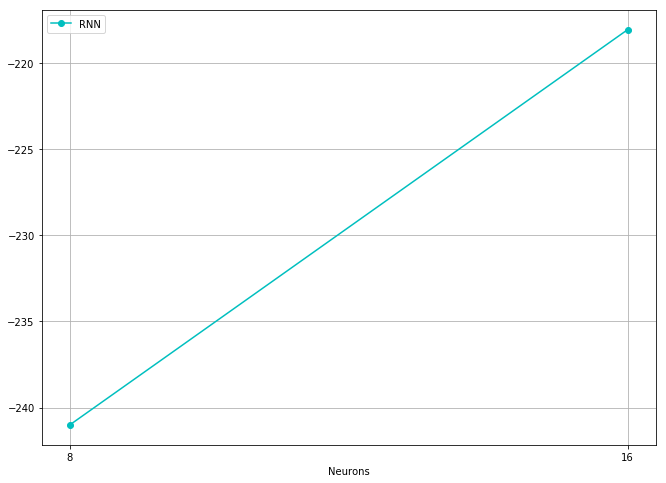

In [14]:
plot_grid_search_results(models_results, "1")